### gather and format data

In [802]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import h5py
import timeit

df = pd.read_csv('sensor_walk_2_clean.csv')
df.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow = pd.read_csv('flow_walk_2_clean.csv')
flow.columns = ['Flow']

df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds
0,0.448956,0.512739,0.420477,0.464948,0.000000,0.000000,0.000000,0.000000,21.0,31.0,47.392183
1,0.446636,0.510616,0.420477,0.462887,-0.126608,-0.115855,0.000000,-0.112511,21.0,31.0,47.401346
2,0.441205,0.502809,0.415176,0.455306,-0.231603,-0.290663,-0.128365,-0.281626,21.0,31.0,47.415113
3,0.434933,0.496681,0.411488,0.451459,-0.345977,-0.388910,-0.195315,-0.306400,21.0,31.0,47.426129
4,0.429211,0.494731,0.409263,0.449147,-0.402309,-0.320287,-0.197527,-0.279396,21.0,31.0,47.437084


In [803]:
flow.head()

,Flow
0,20.752807
1,15.437323
2,17.413745
3,17.153626
4,19.645324


In [804]:
def scaleFlow(flow):
    
    flow_scaled = []
    
    for i in range(0, len(flow)):
        
        flow_scaled.append((flow['Flow'][i] - min(flow['Flow'])) / (max(flow['Flow']) - min(flow['Flow'])))
        
    return pd.DataFrame(flow_scaled, columns = ['Flow'])

flow = scaleFlow(flow)

In [805]:
flow.head()

,Flow
0,0.716521
1,0.670524
2,0.687627
3,0.685376
4,0.706938


In [806]:
def movingAvg(Class, windowSize):
    """
    Create moving average to remove single outliers

    Args:
        Class (list): List of inhale / exhale classes
        Windowsize (int): Size of moving average window

    Returns:
        filteredClass (list): Filtered list of classes
    """
    
    filteredClass = []
    for i in range(0, len(Class)):

        if i < windowSize - 1:
            filteredClass.append(Class[i])

        elif Class[i] != Class[i - 1]:
            if sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize > 1:
                filteredClass.append(2)

            elif sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize < 1:
                filteredClass.append(0)

            else:
                filteredClass.append(Class[i])

        elif Class[i] == Class[i - 1]:
            filteredClass.append(Class[i])
            
    return filteredClass

def classSwitch(Class):
    """
    Class switch function to filter 3 classifiers down to 2 (inhale and exhale)

    Args:
        Class (list): List of inhale / exhale classes

    Returns:
        decisionClass (list): Filtered (with moving average) of resulting simplified class
    """

    decision = []
    for i in range(0, len(Class)):
        
        if Class[i] == 1:
            decision.append(1)
            
        elif Class[i] == 0:
            decision.append(0)
            
        elif Class[i] == 2:
            if len(decision) > 1:
                decision.append(decision[-1])
            else:
                decision.append(2)
            
    return movingAvg(decision, 3)

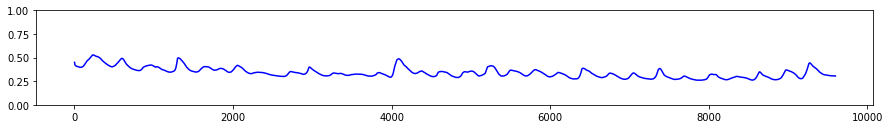

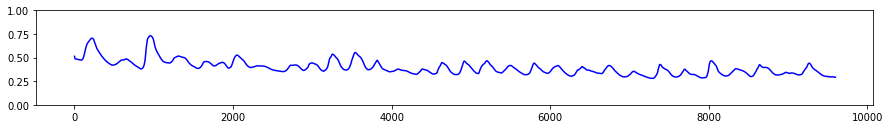

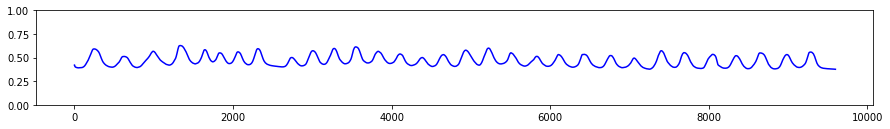

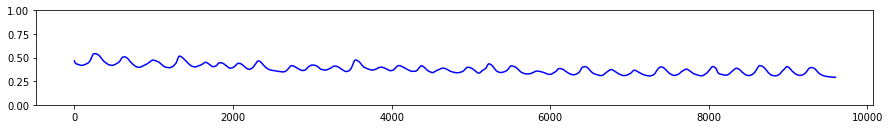

In [807]:
x = range(0, len(df))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.ylim(0, 1)
plt.plot(x, df['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.ylim(0, 1)
plt.plot(x, df['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.ylim(0, 1)
plt.plot(x, df['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.ylim(0, 1)
plt.plot(x, df['4'], 'b')
plt.show()

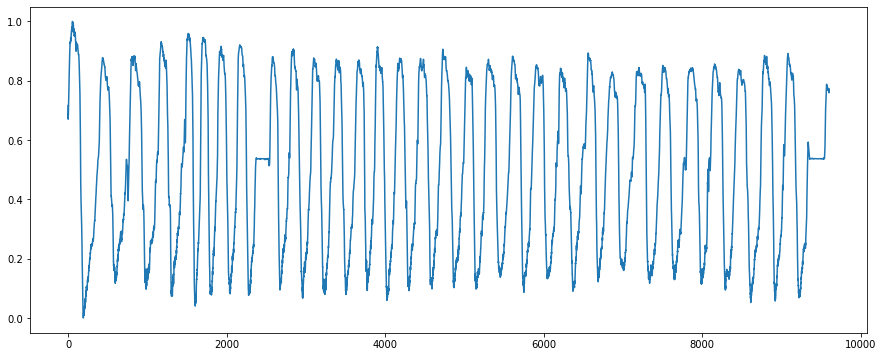

In [808]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow['Flow'])

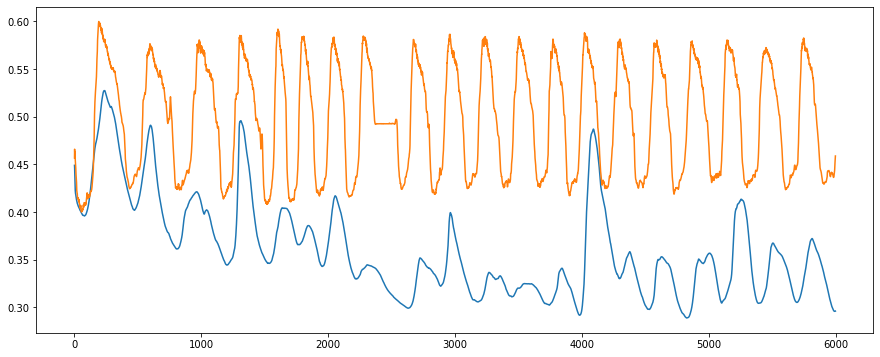

In [809]:
x = range(0, len(df['4'][0:6000]))
flow['a'] = (flow['Flow'] / 5) - 0.6
fig = plt.figure(figsize = (15, 6))
plt.plot(x, df['1'][0:6000], x, flow['a'][0:6000]*-1)

In [810]:
flow.drop('a', inplace = True, axis = 1)

In [811]:
def classLabel(flow):

    upper = 0.82
    lower = 0.2
    
    state = []
    action = []

    for i in range(0, len(flow)):

        if i > len(flow)-2:
            state.append(2)

        else:

            if flow['Flow'][i] < upper and flow['Flow'][i+1] > upper:
                action.append(2)

            if flow['Flow'][i] < lower and flow['Flow'][i+1] > lower:
                action.append(1)

            if flow['Flow'][i] > lower and flow['Flow'][i+1] < lower:
                action.append(2)

            if flow['Flow'][i] > upper and flow['Flow'][i+1] < upper:
                action.append(0)

            if len(action) > 1:
                state.append(action[-1])

            else:
                state.append(2)
                
    return state

df['Class'] = classLabel(flow)

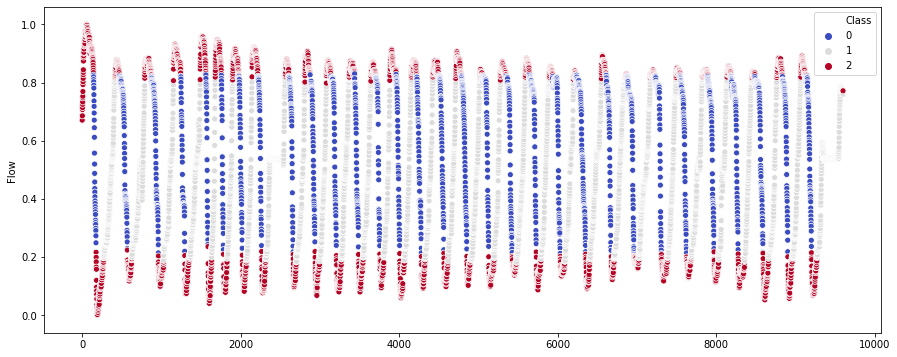

In [812]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow['Flow'], x = range(0, len(flow)), hue = df['Class'], palette = 'coolwarm')

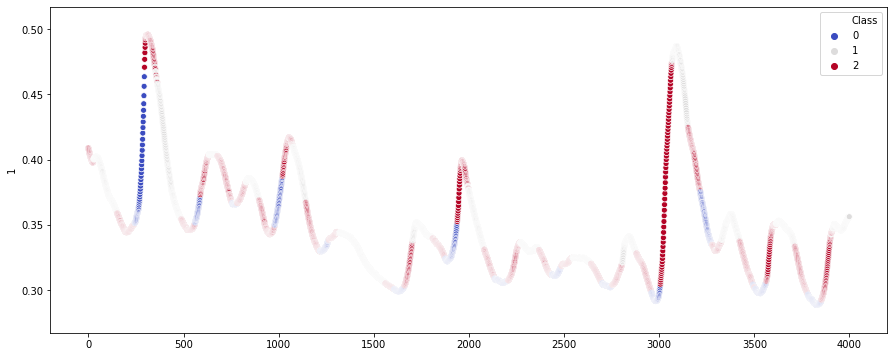

In [813]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df['1'][1000:5000], x = range(0, 4000), hue = df['Class'][1000:5000], palette = 'coolwarm')

In [814]:
df = df[500:]
flow = flow[500:]

In [815]:
# Create the data matrix
X = df.drop('Class', axis = 1)
X.drop('hours', inplace = True, axis = 1)
X.drop('minutes', inplace = True, axis = 1)
X.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
y = df['Class']
y = pd.DataFrame(y, index = None, columns = ['Class'])

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

In [816]:
len(X)

9099

In [817]:
len(y)

9099

### model training - deep learning

In [818]:
# Develop keras sequential model with optimized parameters through grid search cv
model = keras.Sequential()
model.add(keras.layers.Dense(150, activation = tf.nn.relu, input_dim = 8))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Dense(125, activation = tf.nn.relu))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(50, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3, activation = tf.nn.softmax))

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 150)               1350      
_________________________________________________________________
dropout_48 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_49 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_50 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 3)               

In [819]:
EPOCHS = 200
model.fit(X_train, y_train, epochs = EPOCHS)

Epoch 1/200
6369/6369 [==============================] - 0s 62us/sample - loss: 1.0327 - acc: 0.4508
Epoch 2/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.8993 - acc: 0.5623
Epoch 3/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.8044 - acc: 0.6409
Epoch 4/200
6369/6369 [==============================] - 0s 29us/sample - loss: 0.7572 - acc: 0.6642
Epoch 5/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.7280 - acc: 0.6885
Epoch 6/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.7090 - acc: 0.6963
Epoch 7/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.6984 - acc: 0.7036
Epoch 8/200
6369/6369 [==============================] - 0s 29us/sample - loss: 0.6703 - acc: 0.7168
Epoch 9/200
6369/6369 [==============================] - 0s 31us/sample - loss: 0.6783 - acc: 0.7042
Epoch 10/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.6509 - a

6369/6369 [==============================] - 0s 30us/sample - loss: 0.3906 - acc: 0.8333
Epoch 82/200
6369/6369 [==============================] - 0s 31us/sample - loss: 0.3946 - acc: 0.8259
Epoch 83/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.4064 - acc: 0.8262
Epoch 84/200
6369/6369 [==============================] - 0s 29us/sample - loss: 0.4319 - acc: 0.8133
Epoch 85/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.3970 - acc: 0.8307
Epoch 86/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.3829 - acc: 0.8386
Epoch 87/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.3786 - acc: 0.8373
Epoch 88/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.4901 - acc: 0.7959
Epoch 89/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.4054 - acc: 0.8223
Epoch 90/200
6369/6369 [==============================] - 0s 29us/sample - loss: 0.4003 - acc: 

6369/6369 [==============================] - 0s 31us/sample - loss: 0.3195 - acc: 0.8675
Epoch 161/200
6369/6369 [==============================] - 0s 30us/sample - loss: 0.3263 - acc: 0.8634
Epoch 162/200
6369/6369 [==============================] - 0s 35us/sample - loss: 0.3132 - acc: 0.8651
Epoch 163/200
6369/6369 [==============================] - 0s 38us/sample - loss: 0.3187 - acc: 0.8639
Epoch 164/200
6369/6369 [==============================] - 0s 35us/sample - loss: 0.3161 - acc: 0.8648
Epoch 165/200
6369/6369 [==============================] - 0s 33us/sample - loss: 0.3251 - acc: 0.8642
Epoch 166/200
6369/6369 [==============================] - 0s 33us/sample - loss: 0.3169 - acc: 0.8683
Epoch 167/200
6369/6369 [==============================] - 0s 31us/sample - loss: 0.3323 - acc: 0.8554
Epoch 168/200
6369/6369 [==============================] - 0s 32us/sample - loss: 0.3225 - acc: 0.8645
Epoch 169/200
6369/6369 [==============================] - 0s 33us/sample - loss: 0.328

In [820]:
# Scoring the model on testing data from same dataset
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

prediction = model.predict(X_test)

final_pred = []
for score in range(0, len(prediction)):
    final_pred.append(np.argmax(prediction[score]))
    
print(classification_report(y_test, final_pred))
print(confusion_matrix(y_test, final_pred))
Predictions = classSwitch(final_pred)
Class = classSwitch(list(y_test['Class']))
print('Keras Model')
print("\n")
print(classification_report(Class, Predictions))

2730/2730 [==============================] - 0s 61us/sample - loss: 0.2237 - acc: 0.9117
Test accuracy: 0.9117216
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       671
           1       0.95      0.95      0.95      1051
           2       0.91      0.84      0.88      1008

    accuracy                           0.91      2730
   macro avg       0.91      0.92      0.91      2730
weighted avg       0.91      0.91      0.91      2730

[[640   1  30]
 [  0 998  53]
 [100  57 851]]
Keras Model


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1455
           1       0.95      0.88      0.92      1272
           2       1.00      1.00      1.00         3

    accuracy                           0.92      2730
   macro avg       0.95      0.95      0.95      2730
weighted avg       0.93      0.92      0.92      2730



In [821]:
#export_csv = pd.DataFrame(X_test).to_csv(r'/Users/mikefurr/Documents/GitHub/coral_host/Jupyter_Notebooks/X_test.csv', header = True, index = None)

In [822]:
#coral_results = pd.read_csv('coral_results.csv')

In [823]:
#print(classification_report(y_test, coral_results))

### model training - tensorflow random forest

### model training - random forest

In [ ]:
print(" Random Forest ... ")

start = timeit.default_timer()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 5000)
rf_model = classifier.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
end = timeit.default_timer()

print(" accuracy = ", accuracy_score(y_test, predictions), " time = ", end - start)
print(confusion_matrix(y_test, predictions))
print("\n")

print("Random Forest")
print(classification_report(y_test, predictions))

 Random Forest ... 


/Users/mikefurr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
Predictions = classSwitch(predictions)
Class = classSwitch(list(y_test['Class']))
print('Random Forest')
print("\n")
print(classification_report(Class, Predictions))

### model testing on new data

In [ ]:
df_test = pd.read_csv('sensor_walk_1_clean.csv')
df_test.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow_test = pd.read_csv('flow_walk_1_clean.csv')
flow_test.columns = ['Flow']
flow_test = scaleFlow(flow_test)

In [ ]:
df_test['Class'] = classLabel(flow_test)

In [ ]:
x = range(0, len(df_test))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.ylim(0, 1)
plt.plot(x, df_test['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.ylim(0, 1)
plt.plot(x, df_test['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.ylim(0, 1)
plt.plot(x, df_test['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.ylim(0, 1)
plt.plot(x, df_test['4'], 'b')
plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow_test['Flow'])

In [ ]:
flow_test['a'] = (flow_test['Flow'] / 5) - 0.6
fig = plt.figure(figsize = (20, 10))
plt.plot(x, df_test['1'], x, flow_test['a']*-1)

In [ ]:
flow_test.drop('a', inplace = True, axis = 1)

In [ ]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'], x = range(0, len(flow_test)), hue = df_test['Class'], palette = 'coolwarm')

In [ ]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df_test['1'][1000:6000]*-1, x = range(0, 5000), hue = df_test['Class'][1000:6000], palette = 'coolwarm')

In [ ]:
df_test = df_test[1500:]

In [ ]:
test_sensors = df_test.drop('Class', axis = 1)
test_sensors.drop('hours', inplace = True, axis = 1)
test_sensors.drop('minutes', inplace = True, axis = 1)
test_sensors.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
test_class = df_test['Class']
test_class = pd.DataFrame(test_class, index = None, columns = ['Class'])

#### model testing - random forest

In [ ]:
test_predictions = rf_model.predict(test_sensors)
print(" accuracy = ", accuracy_score(test_class, test_predictions))
print(confusion_matrix(test_class, test_predictions))
print("\n")

print('Random Forest - Testing')
print('\n')
print(classification_report(test_class[1000:], test_predictions[1000:]))

In [ ]:
testPredictions = classSwitch(test_predictions)
testClass = classSwitch(list(test_class['Class']))
print('Random Forest - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

In [ ]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1500:], x = range(0, len(flow_test['Flow'][1500:])), hue = test_predictions, palette = 'coolwarm')

### model testing - deep learning

In [ ]:
test_predictions = model.predict(test_sensors)

final_pred_test = []
for score in range(0, len(test_predictions)):
    final_pred_test.append(np.argmax(test_predictions[score]))

print('Keras Model - Testing')
print('\n')
print(classification_report(test_class, final_pred_test))

In [ ]:
testPredictions = classSwitch(final_pred_test)
testClass = classSwitch(list(test_class['Class']))
print('Keras Model - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

In [ ]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'][1000:5000], x = range(0, 4000), hue = final_pred_test[1000:5000], palette = 'coolwarm')

In [ ]:
# Looking at where either model fails
#test_class['score'] = test_class['Class'] == final_pred_test
#fig = plt.figure(figsize = (15, 6))
#sns.scatterplot(y = flow_test['Flow'][1000:], x = range(0, ), hue = test_class['score'][1000:])

#### Save TFLite Model

In [ ]:
#keras_file = "walking_model.h5"
#keras.models.save_model(model, keras_file)
#converter = tf.lite.TocoConverter.from_keras_model_file('walking_model.h5')
#tflite_model = converter.convert()
#open("walking_model.tflite", "wb").write(tflite_model)